# Exercise: Create a Python Package for Cloud-Free Mosaics

In this exercise, your goal is to:

1. Create a function that generates a cloud-free mosaic using Sentinel-2 data and Google Earth Engine.
2. Turn this function into a reusable Python package.
3. Organize your code using proper Python package structure.
4. Install your package locally in editable mode.
5. Test your package using a script or notebook.

## Step 1: Write the Function
Create a function called `create_cloud_free_mosaic(aoi, start_date, end_date)` that:
- Filters Sentinel-2 imagery by date and area,
- Applies a cloud mask using the `QA60` band,
- Returns a cloud-free median composite.

## Step 2: Create the Package Structure
Use the following folder layout:

```
geoapps/
├── geoapps/
│   ├── __init__.py
│   └── lab03/
│       ├── __init__.py
│       └── cloud_mosaic.py  # <- your function goes here
├── pyproject.toml
└── README.md
```

## Step 3: Create `pyproject.toml`
Use the following template:

```toml
[build-system]
requires = ["setuptools", "wheel"]
build-backend = "setuptools.build_meta"

[project]
name = "geoapps"
version = "0.1.0"
requires-python = ">=3.10"
description = "EO utilities for cloud-free mosaics"
authors = [
  { name = "Your Name", email = "your@email.com" }
]

[tool.setuptools.packages.find]
where = ["."]
exclude = ["tests", "notebooks"]
```

## Step 4: Install Your Package
From the root of your project (where `pyproject.toml` is located), run:

```bash
pip install -e .
```

## Step 5: Test the Package
Create a test script or notebook and try importing your function like this:

```python
from geoapps.lab03.cloud_mosaic import create_cloud_free_mosaic

import ee
ee.Initialize(project='your-ee-project-id')

aoi = ee.Geometry.Rectangle([19.8, 50.0, 20.0, 50.2])
mosaic = create_cloud_free_mosaic(aoi, '2023-06-01', '2023-07-01')
print(mosaic.getInfo())
```

In [1]:
from geoapps.lab03.cloud_mosaic import create_cloud_free_mosaic
import geemap
import ee

ee.Initialize(project='ee-skoraremotesensing')

aoi = ee.Geometry.Rectangle([19.8, 50.0, 20.0, 50.2])

# Uzyskaj mozaikę i maskę
mosaic, cloud_mask = create_cloud_free_mosaic(aoi, '2023-06-01', '2023-07-01')

## Step 6: Bonus – Add a Demo Notebook
Create a notebook in a separate `notebooks/` folder where you import and visualize the result using `geemap`:

```python
import geemap
Map = geemap.Map(center=[50.1, 19.9], zoom=10)
Map.addLayer(mosaic, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Mosaic')
Map
```

In [2]:
import geemap
Map = geemap.Map(center=[50.1, 19.9], zoom=10)
Map.addLayer(mosaic, {'min': 0, 'max': 0.3}, 'Cloud-Free Mosaic RGB')
Map.addLayer(cloud_mask, {'palette': ['red']}, 'Cloud Mask Overlay')
Map.addLayerControl()
Map

In [3]:
from geoapps.lab03.cloud_mosaic import create_cloud_free_mosaic
import geemap
import ee
ee.Initialize(project='ee-skoraremotesensing')
aoi = ee.Geometry.Rectangle([19.8, 50.0, 20.0, 50.2])
mosaic = create_cloud_free_mosaic(aoi, '2023-06-02', '2023-07-01')

mosaic

Map(center=[50.09997336373202, 19.899999999999498], controls=(WidgetControl(options=['position', 'transparent_…

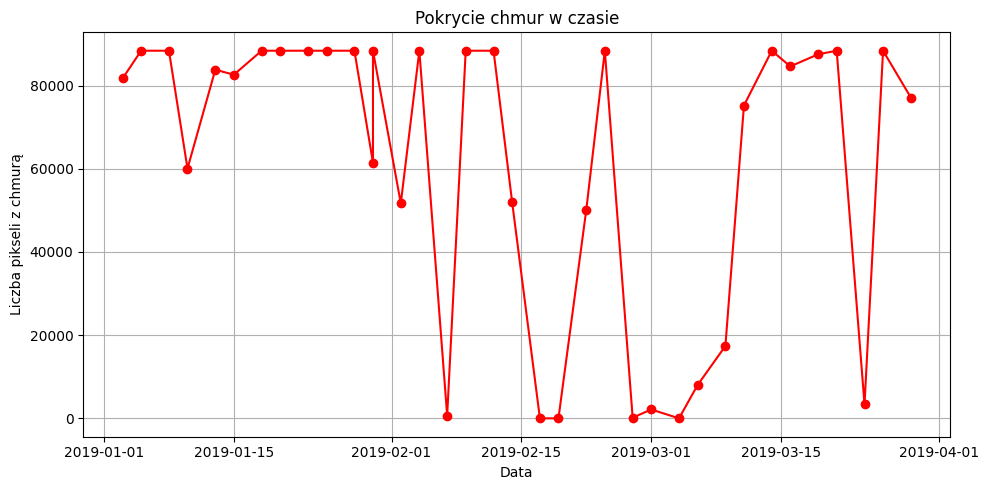

Map(center=[50.099946524150226, 19.899999999999498], controls=(WidgetControl(options=['position', 'transparent…

In [4]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

# Inicjalizacja Earth Engine
ee.Initialize()

# AOI – prostokąt
aoi = ee.Geometry.BBox(19.8, 50.0, 20.0, 50.2)

# Bity QA60
cloud_bit_mask = 1 << 10
cirrus_bit_mask = 1 << 11

# Funkcja do dodania masek
def add_cloud_info(image):
    qa = image.select('QA60')
    cloud = qa.bitwiseAnd(cloud_bit_mask).neq(0).rename('cloud')
    cirrus = qa.bitwiseAnd(cirrus_bit_mask).neq(0).rename('cirrus')
    cloud_free = cloud.Not().And(cirrus.Not()).rename('cloud_free')
    return image.addBands([cloud, cirrus, cloud_free])

# Kolekcja
collection = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(aoi) \
    .filterDate('2019-01-01', '2019-03-30') \
    .map(add_cloud_info)

# Statystyki pokrycia chmur
def compute_cloud_stats(image):
    stats = image.select(['cloud', 'cirrus', 'cloud_free']) \
        .reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=aoi,
            scale=60,
            maxPixels=1e9
        )
    return image.set(stats)

cloud_stats = collection.map(compute_cloud_stats)

# Zbierz dane do pandas
dates = cloud_stats.aggregate_array('system:time_start').getInfo()
clouds = cloud_stats.aggregate_array('cloud').getInfo()

df = pd.DataFrame({
    'date': pd.to_datetime([ee.Date(t).format('YYYY-MM-dd').getInfo() for t in dates]),
    'cloud_pixels': clouds
})

# Wykres
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['cloud_pixels'], marker='o', color='red')
plt.xlabel('Data')
plt.ylabel('Liczba pikseli z chmurą')
plt.title('Pokrycie chmur w czasie')
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔍 WYŚWIETLENIE RGB + MASKI
# Najbardziej zachmurzone zdjęcie
image = collection.sort('cloud', False).first().clip(aoi)

rgb = image.select(['B4', 'B3', 'B2']).divide(10000)
cloud_mask = image.select('cloud').updateMask(image.select('cloud'))

# Mapa
Map = geemap.Map(center=aoi.centroid(1).coordinates().getInfo()[::-1], zoom=10)
Map.addLayer(rgb, {'min': 0, 'max': 0.3}, 'RGB Image')
Map.addLayer(cloud_mask, {'palette': ['red']}, 'Cloud Mask Overlay')
Map.addLayerControl()
Map


In [ ]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-skoraremotesensing')

aoi = ee.Geometry.Rectangle([19.8, 50.0, 20.0, 50.2])
START_DATE = '2023-06-01'
END_DATE = '2023-07-01'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50


def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

s2_sr_cld_col_eval = get_s2_sr_cld_col(aoi, START_DATE, END_DATE)
